<a href="https://colab.research.google.com/github/Paul-mwaura/Deploying-a-Deep-Learning-Model-to-Heroku-Using-Flask.ipynb/blob/main/Deploying_a_Deep_Learning_Model_to_Heroku_Using_Flask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploying a Deep Learning Model to Heroku Using Flask

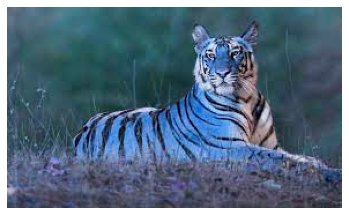

In [2]:
import cv2
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input

# Importing the necessary modules
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input, MobileNetV2

# example image of a tiger
img_path = 'tiger.jpg'
img = cv2.imread(img_path) # read image


plt.axis(False)
plt.imshow(img) # Display the image.

In [3]:
print('Image Dimensions: {} \nMaximum: {} \nMinimum: {}'.format(img.shape, img.max(), img.min()))

Image Dimensions: (174, 290, 3) 
Maximum: 255 
Minimum: 0


### Resize the image to dimensions acceptable by MobileNetV2.

In [4]:
img_resized = cv2.resize(img, (224, 224))
print('Image Dimensions: {} \nMaximum: {} \nMinimum: {}'.format(img_resized.shape,img_resized.max(), img_resized.min()))

Image Dimensions: (224, 224, 3) 
Maximum: 255 
Minimum: 0


### Preprocess the image to have pixels in the range of [-1, 1]

In [5]:
img_preprocessed = preprocess_input(img_resized)
print('Image Dimensions: {} \nMaximum: {} \nMinimum: {}'.format(img_preprocessed.shape, img_preprocessed.max(), img_preprocessed.min()))

Image Dimensions: (224, 224, 3) 
Maximum: 1.0 
Minimum: -1.0


Keras models expect inputs in batches, i.e., multiple images at once. To make prediction using a single image, we add a batch dimension of 1

In [6]:
img_reshaped = img_preprocessed.reshape((1, 224, 224, 3))
print('Batch shape: {}'.format(img_reshaped.shape))

Batch shape: (1, 224, 224, 3)


In [7]:
# creating the model
model = MobileNetV2(input_shape=(224,224,3), weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


### Make predictions

In [8]:
prediction = model.predict(img_reshaped)
print('Predictions shape: {} \nMaximum: {} \nMinimum: {}'.format(prediction.shape, prediction.max(), prediction.min()))

Predictions shape: (1, 1000) 
Maximum: 0.8734257221221924 
Minimum: 1.230501766258385e-06


In [9]:
decoded = decode_predictions(prediction)
decoded

40960/35363 [==================================] - 0s 0us/step


[[('n02129604', 'tiger', 0.8734257),
  ('n02123159', 'tiger_cat', 0.084481),
  ('n02128925', 'jaguar', 0.0036077185),
  ('n02128385', 'leopard', 0.002155192),
  ('n02127052', 'lynx', 0.002132377)]]

### Test New Image

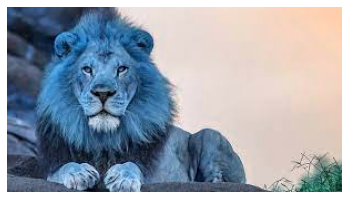

In [10]:
# example image of a tiger
img_path = 'lion.jpg'
img = cv2.imread(img_path) # read image


plt.axis(False)
plt.imshow(img) # Display the image.

In [11]:
img_resized = cv2.resize(img, (224, 224))
img_preprocessed = preprocess_input(img_resized)

img_reshaped = img_preprocessed.reshape((1, 224, 224, 3))
print('Batch shape: {}'.format(img_reshaped.shape))

Batch shape: (1, 224, 224, 3)


In [12]:
prediction = model.predict(img_reshaped)
print('Predictions shape: {} \nMaximum: {} \nMinimum: {}'.format(prediction.shape, prediction.max(), prediction.min()))

Predictions shape: (1, 1000) 
Maximum: 0.35190150141716003 
Minimum: 6.779977411497384e-06


In [13]:
decoded = decode_predictions(prediction)
decoded

[[('n02129165', 'lion', 0.3519015),
  ('n02363005', 'beaver', 0.051866457),
  ('n02112137', 'chow', 0.031943973),
  ('n02127052', 'lynx', 0.025063656),
  ('n02134418', 'sloth_bear', 0.022473002)]]

## Creating a simple Flask application

In [14]:
pip install flask_wtf

     |████████████████████████████████| 174kB 7.0MB/s 


The flask_wtf module facilitates making simple forms in Flask which renders well in html pages. The form above takes an image with the extensions listed and contains a submit button which only works if an image is selected.

In [23]:
pip install flask_bootstrap

In [26]:
model.save_weights('model.h5')

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from flask_wtf import FlaskForm
from flask_wtf.file import FileField, FileRequired, FileAllowed
from wtforms import SubmitField
import os
from werkzeug.utils import secure_filename
from flask import Flask, render_template
from flask import Flask,request,jsonify
import PIL

from array import array
from keras.models import model_from_json
from tensorflow import keras
from keras.preprocessing import image
import numpy as np
import cv2



app = Flask(__name__)
app.config['SECRET_KEY'] = os.environ.get('SECRET_KEY') or 'you-will-never-guess'
bootstrap = Bootstrap(app)
model = MobileNetV2(input_shape=(300,300,3), weights=None)
model.load_weights('model.h5')


class UploadForm(FlaskForm):
    upload = FileField('Select an image:', validators=[
        FileRequired(),
        FileAllowed(['jpg', 'png', 'jpeg', 'JPEG', 'PNG', 'JPG'], 'Images only!')
    ])
    submit = SubmitField('Classify')


def get_prediction(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (300, 300))
    img_preprocessed = preprocess_input(img_resized)
    img_reshaped = img_preprocessed.reshape((1, 300, 300, 3))
    prediction = model.predict(img_reshaped)
    decoded = decode_predictions(prediction)

    top_3 = [(cat.capitalize(), round(prob*100, 2)) for (code, cat, prob) in decoded[0]][:3]
    return top_3


@app.route('/', methods=['GET', 'POST'])
def home():
    form = UploadForm()
    if form.validate_on_submit():
        f = form.upload.data
        filename = secure_filename(f.filename)
        file_url = os.path.join('static', filename
        )
        f.save(file_url)
        form = None
        prediction = get_prediction(file_url)
    else:
        file_url = None
        prediction = None
    return render_template("index.html", form=form, file_url=file_url, prediction=prediction)


if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
